In [1]:
# mount your Google Drive and change the path to where you are storing the scripts and data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import sys, os
import os
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/ece4179/Project')
!ls '/content/gdrive/MyDrive/Colab Notebooks/ece4179/Project'

Mounted at /content/gdrive
BYOL_ResNet101	Course_Project_Tutorial.ipynb  ResNet18_STL10.ipynb
BYOL_ResNet152	dataset_dir		       Supervised_BYOL.ipynb
BYOL_ResNet18	hw3_2.ipynb
BYOL_ResNet50	models


In [2]:
import torch
from torchvision.datasets import STL10 as STL10
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision


from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

import os
import random
from IPython.display import clear_output
from torchsummary import summary
import time
import pandas as pd
from copy import deepcopy
from tqdm import tqdm

#All images are 3x96x96
image_size = 96
#Example batch size
batch_size = 32
#Define the chosen model type
chosen_model = torchvision.models.resnet18()

In [3]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


<h3>Create training and validation split</h3>

In [4]:
dataset_dir = '/content/gdrive/MyDrive/Colab Notebooks/ece4179/Project/dataset_dir'

#Load train and validation sets
trainval_set = STL10(dataset_dir, split='train', transform=transforms.ToTensor(), download=True)

#Use 10% of data for training - simulating low data scenario
num_train = int(len(trainval_set)*0.1)

#Split data into train/val sets
torch.manual_seed(0) #Set torch's random seed so that random split of data is reproducible
train_set, val_set = random_split(trainval_set, [num_train, len(trainval_set)-num_train])

#Load test set
test_set = STL10(dataset_dir, split='test', transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


<h3>Get the unlabelled data</h3>

In [5]:
unlabelled_set = STL10(dataset_dir, split='unlabeled', transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


<h3>Create the four dataloaders</h3>

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size)
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_set, shuffle=True, batch_size=batch_size)

valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [7]:
#This Function will allow us to scale an image's pixel values to a value between 0 and 1
#It will undo the Normalisation that the Dataset performs
def normalize_img(img):
    mins = img.min(0, keepdims = True).min(1, keepdims = True)
    maxs = img.max(0, keepdims = True).max(1, keepdims = True)
    return (img - mins)/(maxs - mins)

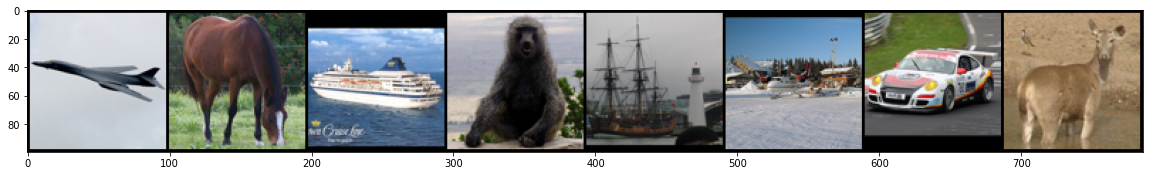

In [8]:
plt.figure(figsize = (20,10))
images, labels = next(iter(train_loader))
out = torchvision.utils.make_grid(images[0:8])
plt.imshow(normalize_img(out.numpy().transpose((1, 2, 0))))

In [9]:
class SupervisedModel():
    def __init__(self, encoder):
        self.model = encoder.cuda()

    @staticmethod
    def count_correct(
        y_pred: torch.Tensor,
        y_true: torch.Tensor
    ) -> torch.Tensor:
        """
        Returns the number of correct predictions
        """
        preds = torch.argmax(y_pred, dim=1)
        return (preds == y_true).float().sum()


    def validate_model(
        self,
        loss_fn, 
        dataloader: DataLoader
    ):
        """
        Validates given model with given loss function on given DataLoader
        """
        loss = 0
        correct = 0
        all = 0
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                y_pred = self.model(X_batch)
                all += len(y_pred)
                loss += loss_fn(y_pred, y_batch)
                correct += SupervisedModel.count_correct(y_pred, y_batch)
        return loss / all, correct / all


    def train_model(
        self,
        optimiser: optim.Optimizer,
        loss_fn,
        train_dl: DataLoader,
    ):
        """
        Trains given model with given loss function on given DataLoader
        """
        self.model.train()

        for X_batch, y_batch in train_dl:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            y_pred = self.model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            loss.backward()
            optimiser.step()
            optimiser.zero_grad() 

        self.model.eval() 

    def fit(
        self,
        loss_fn,
        train_dl: DataLoader,
        val_dl: DataLoader,
        test_dl = DataLoader,
        epochs=50
    ) -> dict:
        """
        Trains model and validates on training and validation data
        """
        results = {"train_loss": [], "train_acc": [], "val_loss": [],
                   "val_acc": [], "test_loss": [], "test_acc": []}

        optimiser = optim.AdamW(self.model.parameters())  

        for epoch in range(epochs):
            start = time.time()

            self.train_model(optimiser, loss_fn, train_dl)
            train_loss, train_acc = self.validate_model(loss_fn, train_dl) 
            val_loss, val_acc = self.validate_model(loss_fn, val_dl)
            test_loss, test_acc = self.validate_model(loss_fn, test_dl)

            print(f"Epoch {epoch + 1}: Training loss = {train_loss:.3f} "
             f"(acc: {train_acc:.3f}), Validation loss = {val_loss:.3f} "
             f"(acc: {val_acc:.3f}), Testing loss = {test_loss:.3f} "
             f"(acc: {test_acc:.3f}), time {time.time() - start:.1f}s")
            results["train_loss"].append(float(train_loss))
            results["train_acc"].append(float(train_acc))
            results["val_loss"].append(float(val_loss))
            results["val_acc"].append(float(val_acc))
            results["test_loss"].append(float(test_loss))
            results["test_acc"].append(float(test_acc))

        return results

def evaluate_baseline():
    encoder = chosen_model
    num_ftrs = encoder.fc.in_features
    #redefine the last fc layer with a linear layer with 10 ouputs, this layer's weights will be randomly initialised
    encoder.fc = nn.Linear(num_ftrs, 10)

    baseline_model = SupervisedModel(encoder)

    loss_fn = nn.CrossEntropyLoss(reduction='sum')

    return baseline_model.fit(loss_fn, train_loader, valid_loader, test_loader)

history_baseline = evaluate_baseline()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: Training loss = 2.944 (acc: 0.130), Validation loss = 2.978 (acc: 0.130), Testing loss = 2.972 (acc: 0.129), time 6.4s
Epoch 2: Training loss = 2.081 (acc: 0.250), Validation loss = 2.363 (acc: 0.223), Testing loss = 2.373 (acc: 0.217), time 5.8s
Epoch 3: Training loss = 1.328 (acc: 0.550), Validation loss = 2.314 (acc: 0.261), Testing loss = 2.317 (acc: 0.258), time 5.8s
Epoch 4: Training loss = 0.757 (acc: 0.754), Validation loss = 2.471 (acc: 0.304), Testing loss = 2.437 (acc: 0.313), time 5.9s
Epoch 5: Training loss = 0.596 (acc: 0.806), Validation loss = 2.687 (acc: 0.332), Testing loss = 2.644 (acc: 0.339), time 5.8s
Epoch 6: Training loss = 0.573 (acc: 0.796), Validation loss = 2.931 (acc: 0.303), Testing loss = 2.960 (acc: 0.300), time 5.7s
Epoch 7: Training loss = 0.449 (acc: 0.848), Validation loss = 2.700 (acc: 0.342), Testing loss = 2.761 (acc: 0.341), time 5.9s
Epoch 8: Training loss = 0.153 (acc: 0.958), Validation loss = 2.789 (acc: 0.344), Testing loss = 2.811 

In [10]:
class Solarization(nn.Module):
    def __call__(self, x):
        return transforms.functional.solarize(x, threshold=0.5)

def augmentation_tau_prime(p_blur=0.1, p_solarize=0.2):
    return nn.Sequential(
        transforms.RandomResizedCrop(96),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
        )
    )

def augmentation_tau():
    return nn.Sequential(
        transforms.RandomResizedCrop(96),
        transforms.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
        )
    )

In [11]:
class BYOL(nn.Module):
    def __init__(self,
                 model,
                 augmentation,
                 augmentation_prime,
                 encoder_out_shape = 1000,
                 projection_size = 256,
                 tau = 0.999):
        super().__init__()       
        self.encoder_online = model
        self.projector_online = BYOL.mlp(encoder_out_shape, projection_size) # Create a network for projection
        self.online_common = nn.Sequential(self.encoder_online,
                                           self.projector_online)  # Encoder and projector are the same for target and online network
        
        self.predictor_online = BYOL.mlp(projection_size, projection_size)
        self.online = nn.Sequential(self.online_common, self.predictor_online) # Whole online network

        self.target = deepcopy(self.online_common) # Target network without prediction head

        self.tau = tau # Tau for moving exponential average
        self.augmentation = augmentation
        self.augmentation_prime = augmentation_prime

        self.loss_fn = nn.MSELoss(reduction="sum") # Loss function for comparision of outputs of two networks
        self.optimiser = optim.AdamW(self.online.parameters()) # Optimizer, diffrent than in paper

    @staticmethod
    def mlp(dim_in: int,
            projection_size: int,
            hidden_size: int = 4096
            ) -> nn.Module:
        return nn.Sequential(
                nn.Linear(dim_in, hidden_size), # a linear layer with output size 4096
                nn.BatchNorm1d(hidden_size), # followed by batch normalization,
                nn.ReLU(inplace=True), # rectified linear units (ReLU),
                nn.Linear(hidden_size, projection_size)) # and a final linear layer with output dimension 256

    def fit(self,
            train_dl: DataLoader,
            val_dl: DataLoader,
            epochs: int
        ) -> dict:
        results = {"train_loss": [], "val_loss": []}

        for epoch in range(epochs):
            start = time.time()
            self.train_one_epoch(train_dl) # Train (fit) model on unlabelled data

            train_loss = self.validate(train_dl) # Validate on unlabelled train data
            val_loss = self.validate(val_dl) # Validate on validation data (labels omitted)

            # Print results
            print(f"Epoch {epoch+1}: train loss = {train_loss:.4f}, validation "
                f"loss = {val_loss:.4f}, time "
                f"{((time.time() - start)/60):.1f} min")
            results["train_loss"].append(float(train_loss))
            results["val_loss"].append(float(val_loss))

        return results

    def train_one_epoch(self,
                        train_dl: DataLoader
        ):
        self.online.train()
        self.target.train()

        for X_batch, y_batch in tqdm(train_dl):
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            loss = self.forward(X_batch)

            loss.backward()
            self.optimiser.step()
            self.optimiser.zero_grad() 

            self.update_target()

        self.target.eval()
        self.online.eval()

        
    def forward(self,
                X_batch: torch.Tensor
        ) -> torch.Tensor:
        with torch.no_grad():
            v, v_prime = self.augmentation(X_batch), self.augmentation_prime(X_batch)

        pred1, pred2 = self.online(v), self.online(v_prime)
        pred1, pred2 = F.normalize(pred1), F.normalize(pred2)
        with torch.no_grad():
            z1, z2 = self.target(v_prime), self.target(v)
            z1, z2 = F.normalize(z1), F.normalize(z2)

        return self.loss_fn(pred1, z1) + self.loss_fn(pred2, z2)
    
    
    def update_target(self):
        for p_online, p_target in zip(self.online_common.parameters(),
                                      self.target.parameters()):
            p_target.data = self.tau * p_target.data + (1 - self.tau) * p_online.data


    def validate(self,
                 dataloader: DataLoader
        ) -> torch.Tensor:
        loss = 0
        all = 0
        for X_batch, y_batch in tqdm(dataloader):
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            with torch.no_grad():
                loss += self.forward(X_batch)
            all += len(X_batch)
        return loss / all


encoder = torchvision.models.resnet18()
num_ftrs = encoder.fc.in_features
encoder.fc = nn.Identity()

model = BYOL(encoder, augmentation_tau(), augmentation_tau_prime(),
                encoder_out_shape = num_ftrs).cuda()
history_unsupervised = model.fit(unlabelled_loader, train_loader, 5)

100%|██████████| 16/16 [00:00<00:00, 32.21it/s]


Epoch 1: train loss = 0.7748, validation loss = 0.7161, time 5.0 min


100%|██████████| 16/16 [00:00<00:00, 32.10it/s]


Epoch 2: train loss = 0.7463, validation loss = 0.7910, time 5.0 min


100%|██████████| 16/16 [00:00<00:00, 32.05it/s]


Epoch 3: train loss = 0.7090, validation loss = 0.9716, time 5.0 min


100%|██████████| 16/16 [00:00<00:00, 31.95it/s]


Epoch 4: train loss = 0.6353, validation loss = 0.4059, time 5.0 min


100%|██████████| 16/16 [00:00<00:00, 32.19it/s]

Epoch 5: train loss = 0.6034, validation loss = 0.5569, time 5.0 min


In [12]:
state_dict = model.encoder_online.state_dict()
encoder_post = chosen_model
num_ftrs_post = encoder_post.fc.in_features
encoder_post.fc = nn.Identity()
encoder_post.load_state_dict(state_dict)

encoder_post.fc = nn.Linear(num_ftrs_post, 10)

semi_sup_model = SupervisedModel(encoder_post)
loss_fn = nn.CrossEntropyLoss(reduction='sum')
history = semi_sup_model.fit(loss_fn, train_loader, valid_loader, test_loader)

Epoch 1: Training loss = 2.324 (acc: 0.094), Validation loss = 2.326 (acc: 0.110), Testing loss = 2.324 (acc: 0.111), time 5.8s
Epoch 2: Training loss = 1.817 (acc: 0.272), Validation loss = 1.901 (acc: 0.253), Testing loss = 1.901 (acc: 0.257), time 5.8s
Epoch 3: Training loss = 1.614 (acc: 0.364), Validation loss = 1.754 (acc: 0.311), Testing loss = 1.748 (acc: 0.317), time 5.7s
Epoch 4: Training loss = 1.601 (acc: 0.394), Validation loss = 1.833 (acc: 0.324), Testing loss = 1.833 (acc: 0.320), time 5.7s
Epoch 5: Training loss = 1.287 (acc: 0.530), Validation loss = 1.592 (acc: 0.392), Testing loss = 1.593 (acc: 0.386), time 5.7s
Epoch 6: Training loss = 1.139 (acc: 0.600), Validation loss = 1.552 (acc: 0.421), Testing loss = 1.542 (acc: 0.418), time 5.7s
Epoch 7: Training loss = 1.090 (acc: 0.602), Validation loss = 1.605 (acc: 0.411), Testing loss = 1.611 (acc: 0.411), time 5.8s
Epoch 8: Training loss = 0.952 (acc: 0.666), Validation loss = 1.663 (acc: 0.418), Testing loss = 1.641 

# Evaluation

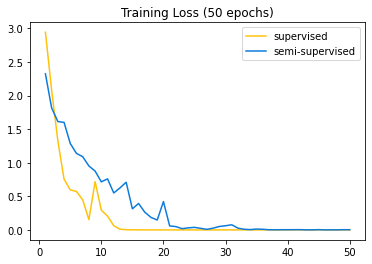

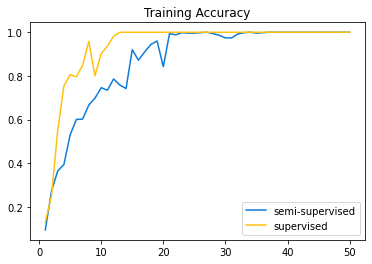

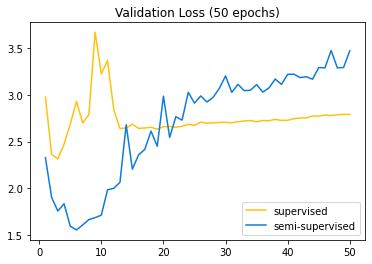

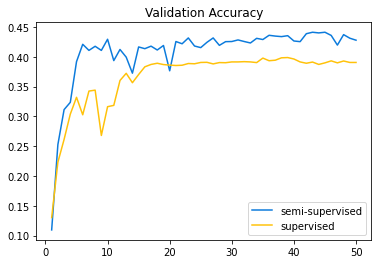

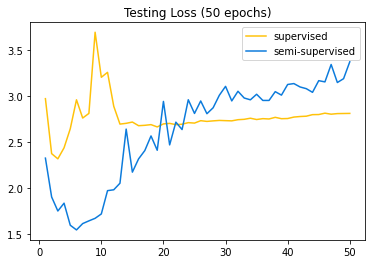

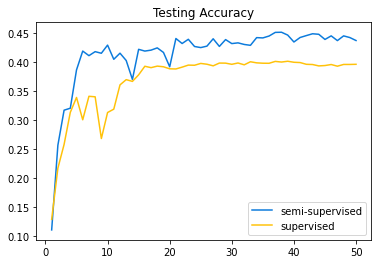

In [13]:

import matplotlib.pyplot as plt

epochs_x = list(range(1, 51))

plt.plot(epochs_x, history_baseline["train_loss"], "#FFC20A", label="supervised")
plt.plot(epochs_x, history["train_loss"], "#0C7BDC", label="semi-supervised")
plt.title("Training Loss (50 epochs)")
plt.legend()
plt.show()

plt.plot(epochs_x, history["train_acc"], "#0C7BDC", label="semi-supervised")
plt.plot(epochs_x, history_baseline["train_acc"], "#FFC20A", label="supervised")
plt.title("Training Accuracy")
plt.legend()
plt.show()

plt.plot(epochs_x, history_baseline["val_loss"], "#FFC20A", label="supervised")
plt.plot(epochs_x, history["val_loss"], "#0C7BDC", label="semi-supervised")
plt.title("Validation Loss (50 epochs)")
plt.legend()
plt.show()

plt.plot(epochs_x, history["val_acc"], "#0C7BDC", label="semi-supervised")
plt.plot(epochs_x, history_baseline["val_acc"], "#FFC20A", label="supervised")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs_x, history_baseline["test_loss"], "#FFC20A", label="supervised")
plt.plot(epochs_x, history["test_loss"], "#0C7BDC", label="semi-supervised")
plt.title("Testing Loss (50 epochs)")
plt.legend()
plt.show()

plt.plot(epochs_x, history["test_acc"], "#0C7BDC", label="semi-supervised")
plt.plot(epochs_x, history_baseline["test_acc"], "#FFC20A", label="supervised")
plt.title("Testing Accuracy")
plt.legend()
plt.show()

In [14]:
print("The total test accuracy is: %.2f%%" %(history["test_acc"][-1]*100))

The total test accuracy is: 43.65%


# Confusion Matrix

In [15]:
m = nn.Softmax(dim=1)

def confusionMatrix(net, device, loader, predictedLabel, actualLabel):
    
    net.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            
            fx = net(x.to(device))
            
            softout = m(fx.to(device))

            for k in range(len(softout)):
                value, indx = torch.max(softout[k], 0)
                predictedLabel.append(indx.cpu().detach().numpy().item())
                actualLabel.append(y.to(device)[k].cpu().detach().numpy().item())             
        
    return predictedLabel, actualLabel

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

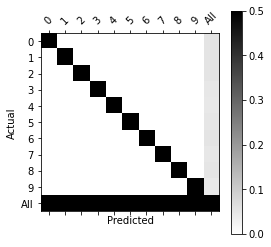

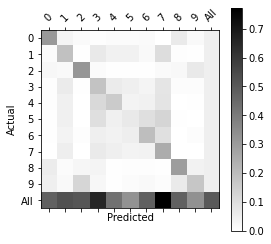

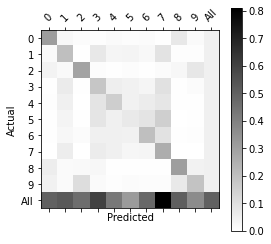

In [16]:
training_pred, validation_pred, testing_pred = [], [], []
training_actual, validation_actual, testing_actual = [], [], []

training_pred, training_actual = confusionMatrix(encoder_post, device, train_loader, training_pred, training_actual)
validation_pred, validation_actual = confusionMatrix(encoder_post, device, valid_loader, validation_pred, validation_actual)
testing_pred, testing_actual = confusionMatrix(encoder_post, device, test_loader, testing_pred, testing_actual)

training_actual = pd.Series(training_actual, name='Training Actual')
training_pred = pd.Series(training_pred, name='Training Predicted')
df_confusion_training = pd.crosstab(training_actual, training_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm_training = df_confusion_training / df_confusion_training.sum(axis=1)

validation_actual = pd.Series(validation_actual, name='Validation Actual')
validation_pred = pd.Series(validation_pred, name='Validation Predicted')
df_confusion_validation = pd.crosstab(validation_actual, validation_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm_validation = df_confusion_validation / df_confusion_validation.sum(axis=1)

testing_actual = pd.Series(testing_actual, name='Testing Actual')
testing_pred = pd.Series(testing_pred, name='Testing Predicted')
df_confusion_testing = pd.crosstab(testing_actual, testing_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm_testing = df_confusion_testing / df_confusion_testing.sum(axis=1)


plot_confusion_matrix(df_conf_norm_training)

plot_confusion_matrix(df_conf_norm_validation)

plot_confusion_matrix(df_conf_norm_testing)